In [384]:
import json
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif,  chi2
from sklearn import svm
from scipy.sparse import csr_matrix
from collections import Counter
from sklearn.metrics import f1_score, recall_score, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV




In [385]:
dom1 = []
dom2 = []
test_set = []
with open('data/domain1_train.json', 'r') as file:
    for line in file:
        dom1.append(json.loads(line))
        
with open('data/domain2_train.json', 'r') as file:
    for line in file:
        dom2.append(json.loads(line))
        
        
with open('data/test_set.json', 'r') as file:
    for line in file:
        test_set.append(json.loads(line))
        
dom1 = pd.DataFrame.from_dict(dom1)
dom2 = pd.DataFrame.from_dict(dom2)
dom2 = dom2[dom2['text'].apply(len) > 0]
kaggle_set = pd.DataFrame.from_dict(test_set)
        

In [386]:
print(len(dom1))
print(len(dom2))
print(len(test_set))

19500
14899
1000


In [387]:
dom1['label'].value_counts()
print(len(dom2.loc[dom2['label']==0]))
print(len(dom2.loc[dom2['label']==1]))

12750
2149


### EDA

count frequencies of words 


In [388]:
def word_freq(domain):
    counter = Counter()
    for text in domain['text']:
        counter = dict(Counter(text) + Counter(counter))
    
    token_id = list(counter.keys())
    token_count = list(counter.values())

    print("The mean count of word frequency is: ", np.mean(token_count))

    plt.figure(figsize=(8,4))
    plt.bar(token_id, token_count)
    plt.xlabel("frequency")
    plt.xlim([0, 200])
    plt.title("Word freqency of the domain")
    plt.show()



In [389]:
# split human and machine texts

dom1_grouped = dom1.groupby('label')
dom2_grouped = dom2.groupby('label')

dom1_ai = dom1_grouped.get_group(0)  
dom1_man = dom1_grouped.get_group(1)  
dom2_ai = dom2_grouped.get_group(0)  
dom2_man = dom2_grouped.get_group(1) 

The mean count of word frequency is:  112.85600354452814


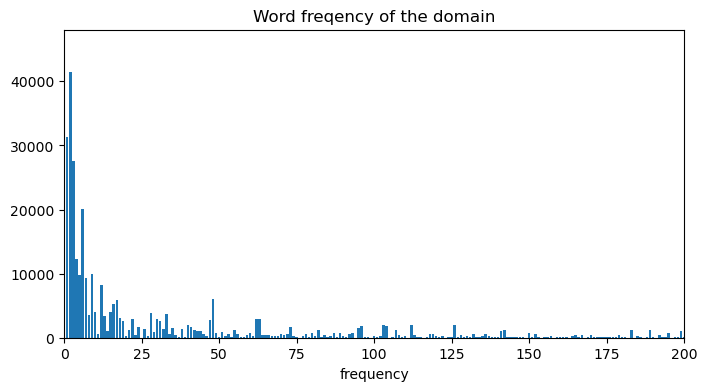

In [390]:
word_freq(dom1_ai)

The mean count of word frequency is:  55.002274607113314


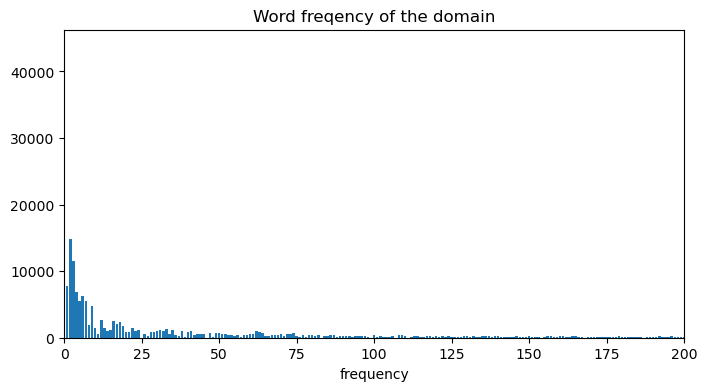

In [391]:
word_freq(dom1_man)

The mean count of word frequency is:  377.156054174247


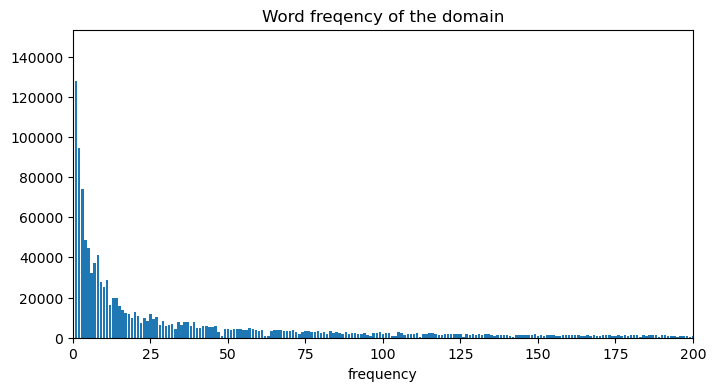

In [392]:
word_freq(dom2_ai)

The mean count of word frequency is:  94.92816442816442


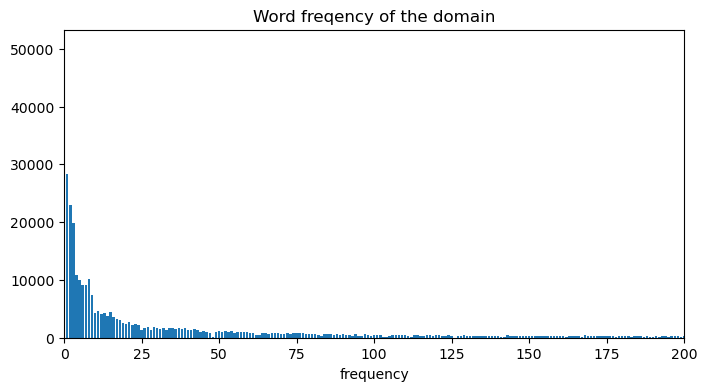

In [393]:
word_freq(dom2_man)

check length of instances

In [394]:
print("Average length of instances in each domain: \n")

print("domain 1 AI")
print(dom1_ai['text'].str.len().mean())
print("domain 1 human")
print(dom1_man['text'].str.len().mean())
print("domain 2 AI")
print(dom2_ai['text'].str.len().mean())
print("domain 2 human")
print(dom2_man['text'].str.len().mean())

Average length of instances in each domain: 

domain 1 AI
52.249435897435895
domain 1 human
27.281128205128205
domain 2 AI
146.33654901960784
domain 2 human
217.06700791065612


### 抽取dom1的一部分human到dom2

In [395]:
# # 随机抽取dom1中一部分label=1的数据
# num_samples = 2000  # 你可以根据需要调整要移动的样本数量
# dom1_human_subset = dom1[dom1['label'] == 1].sample(num_samples, random_state=42)

# # 将抽取的数据添加到dom2中
# dom2 = pd.concat([dom2, dom1_human_subset], ignore_index=True)

### Add feature: text length

In [396]:
dom1.head()

,text,label
0,"[70, 746, 825, 109, 2083, 0, 2, 0, 0, 0, 9, 0,...",1
1,"[1209, 179, 1952, 4, 4959, 7, 0, 2, 978, 1522,...",1
2,"[287, 3, 3330, 0, 23, 12, 13, 465, 74, 8, 0, 8...",1
3,"[0, 0, 3, 592, 19, 2, 706, 1439, 2575, 7, 2, 0...",1
4,"[9, 2, 110, 12, 42, 32, 44, 361, 9, 3860, 2358...",1


### train model with dom2

In [397]:
d2_train,d2_test,y2_train,y2_test = train_test_split(dom2,dom2['label'],test_size=0.2)
print(d2_train.shape)
print(d2_test.shape)

(11919, 3)
(2980, 3)


In [398]:
import pandas as pd


dom2_80_percent_count = int(len(dom2) * 0.8)

dom2_80_percent = dom2.iloc[:dom2_80_percent_count]

merged_dataset = pd.concat([dom1, dom2_80_percent], ignore_index=True)



In [399]:
d1_train, d1_test,y1_train,y1_test = train_test_split(merged_dataset, merged_dataset['label'],test_size=0.2)
print(d1_train.shape)
print(d1_test.shape)

(25135, 3)
(6284, 3)


In [400]:
from gensim.models import Word2Vec
from sklearn.svm import SVC
import numpy as np


X = d2_train['text'].tolist()
X1 =d2_test['text'].tolist()
max_length = max([len(seq) for seq in X])
max_length1 = max([len(seq) for seq in X1])
word2vec = Word2Vec(X, vector_size=300, window=10, min_count=1, workers=4)
word2vec1 = Word2Vec(X1, vector_size=300, window=10, min_count=1, workers=4)

def get_text_vector(text, word2vec_model):
    vector_list = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv.index_to_key]
    if len(vector_list) == 0:
        return np.zeros(word2vec.vector_size)
    return np.mean(vector_list, axis=0)

X_train = np.array([get_text_vector(text, word2vec) for text in X])
X_test = np.array([get_text_vector(text, word2vec1) for text in X1])


In [401]:
from gensim.models import Word2Vec
from sklearn.svm import SVC
import numpy as np


X2 = d1_train['text'].tolist()
X3 =d1_test['text'].tolist()
max_length = max([len(seq) for seq in X2])
max_length1 = max([len(seq) for seq in X3])
word2vec = Word2Vec(X2, vector_size=300, window=10, min_count=1, workers=4)
word2vec1 = Word2Vec(X3, vector_size=300, window=10, min_count=1, workers=4)

def get_text_vector(text, word2vec_model):
    vector_list = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv.index_to_key]
    if len(vector_list) == 0:
        return np.zeros(word2vec.vector_size)
    return np.mean(vector_list, axis=0)

X_train1 = np.array([get_text_vector(text, word2vec) for text in X2])
X_test1 = np.array([get_text_vector(text, word2vec1) for text in X3])



In [402]:
X_train.shape


(11919, 300)

In [415]:
X_train = X_train.reshape((11919, 300, 1))
X_test = X_test.reshape((2980, 300, 1))
X_train1 = X_train1.reshape((25135, 300, 1))
X_test1 = X_test1.reshape((6284, 300, 1))



In [416]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
import tensorflow as tf


model = Sequential([
    Conv1D(32, 3, padding='same', input_shape=(300, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(2),

    Conv1D(64, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(2),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(2, activation='softmax')
])

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', f1_metric])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y2_train), y=y2_train)


class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

model.fit(X_train, y2_train, epochs=100, batch_size=64, class_weight=class_weights_dict)




Epoch 1/100
187/187 [==============================] - 8s 33ms/step - loss: 0.8755 - accuracy: 0.2995 - f1_metric: 0.2497
Epoch 2/100
187/187 [==============================] - 6s 33ms/step - loss: 0.6884 - accuracy: 0.7731 - f1_metric: 0.2495
Epoch 3/100
187/187 [==============================] - 5s 27ms/step - loss: 0.6852 - accuracy: 0.8127 - f1_metric: 0.2503
Epoch 4/100
187/187 [==============================] - 4s 23ms/step - loss: 0.6931 - accuracy: 0.7296 - f1_metric: 0.2505
Epoch 5/100
187/187 [==============================] - 5s 24ms/step - loss: 0.6854 - accuracy: 0.8127 - f1_metric: 0.2507
Epoch 6/100
187/187 [==============================] - 5s 27ms/step - loss: 0.6936 - accuracy: 0.8116 - f1_metric: 0.2495
Epoch 7/100
187/187 [==============================] - 5s 27ms/step - loss: 0.7085 - accuracy: 0.7272 - f1_metric: 0.2495
Epoch 8/100
187/187 [==============================] - 7s 39ms/step - loss: 0.6947 - accuracy: 0.4006 - f1_metric: 0.2492
Epoch 9/100
187/187 [===

In [417]:
test_loss, test_acc, test_f1 = model.evaluate(X_test, y2_test, verbose=2)
print("\nTest accuracy:", test_acc)
print("Test F1 Score:", test_f1)



94/94 - 1s - loss: 0.6954 - accuracy: 0.1433 - f1_metric: 0.2465 - 1s/epoch - 11ms/step

Test accuracy: 0.14328859746456146
Test F1 Score: 0.24654752016067505


In [418]:
from tensorflow.keras.layers import Dropout, BatchNormalization

for layer in model.layers[:-1]:
    layer.trainable = False


x = Dense(128, activation='relu')(model.layers[-2].output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(2, activation='softmax')(x)

new_model = Model(inputs=model.input, outputs=output_layer)


new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy', f1_metric])

class_weights1 = compute_class_weight(class_weight='balanced', classes=np.unique(y1_train), y=y1_train)
class_weights_dict1 = {i : class_weights1[i] for i in range(len(class_weights1))}


new_model.fit(X_train1, y1_train, epochs=20, batch_size=64, class_weight=class_weights_dict1)






Epoch 1/20
393/393 [==============================] - 6s 11ms/step - loss: 1.0645 - accuracy: 0.5059 - f1_metric: 0.5464
Epoch 2/20
393/393 [==============================] - 4s 11ms/step - loss: 1.0597 - accuracy: 0.5053 - f1_metric: 0.5464
Epoch 3/20
393/393 [==============================] - 4s 10ms/step - loss: 1.0350 - accuracy: 0.5102 - f1_metric: 0.5460
Epoch 4/20
393/393 [==============================] - 4s 10ms/step - loss: 1.0215 - accuracy: 0.5118 - f1_metric: 0.5467
Epoch 5/20
393/393 [==============================] - 4s 10ms/step - loss: 1.0073 - accuracy: 0.5166 - f1_metric: 0.5466
Epoch 6/20
393/393 [==============================] - 4s 10ms/step - loss: 1.0104 - accuracy: 0.5149 - f1_metric: 0.5465
Epoch 7/20
393/393 [==============================] - 4s 10ms/step - loss: 0.9682 - accuracy: 0.5198 - f1_metric: 0.5461
Epoch 8/20
393/393 [==============================] - 4s 10ms/step - loss: 0.9844 - accuracy: 0.5118 - f1_metric: 0.5469
Epoch 9/20
393/393 [============

In [419]:
test_loss, test_acc, test_f1 = new_model.evaluate(X_test1, y1_test, verbose=2)
print("\nTest accuracy:", test_acc)
print("Test F1 Score:", test_f1)

197/197 - 2s - loss: 0.6961 - accuracy: 0.5821 - f1_metric: 0.5436 - 2s/epoch - 11ms/step

Test accuracy: 0.5821133255958557
Test F1 Score: 0.543595552444458


In [420]:
X4 = kaggle_set['text'].tolist()

max_length = max([len(seq) for seq in X4])

word2vec = Word2Vec(X4, vector_size=300, window=10, min_count=1, workers=4)

kaggle_set_new = np.array([get_text_vector(text, word2vec) for text in X4])


In [421]:
kaggle_set_new.reshape((1000, 300, 1))

array([[[ 0.03181312],
        [ 0.43726015],
        [ 0.0588712 ],
        ...,
        [ 0.03668137],
        [ 0.15535688],
        [-0.11500212]],

       [[-0.09907095],
        [ 0.34570307],
        [-0.04401002],
        ...,
        [ 0.01859575],
        [ 0.13019289],
        [-0.19991793]],

       [[ 0.02656305],
        [ 0.3934258 ],
        [ 0.06040486],
        ...,
        [ 0.02979763],
        [ 0.15637365],
        [-0.07055347]],

       ...,

       [[ 0.05970842],
        [ 0.40813816],
        [ 0.08751746],
        ...,
        [ 0.03068293],
        [ 0.16114159],
        [-0.04286614]],

       [[ 0.04367648],
        [ 0.45162386],
        [ 0.06921319],
        ...,
        [ 0.03825692],
        [ 0.16092758],
        [-0.10452046]],

       [[-0.02823319],
        [ 0.4011354 ],
        [ 0.01034102],
        ...,
        [ 0.0316164 ],
        [ 0.15108414],
        [-0.15097699]]], dtype=float32)

In [429]:

predictions = new_model.predict(kaggle_set_new)
predictions = np.argmax(predictions, axis=1)

32/32 [==============================] - 0s 10ms/step


In [427]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [428]:
import pandas as pd

# 创建一个包含id和class列的DataFrame
df = pd.DataFrame({'id': range(len(predictions)), 'class': predictions})

# 显示DataFrame
print(df)

# 保存DataFrame到CSV文件
df.to_csv('predictions2.csv', index=False)


      id  class
0      0      1
1      1      1
2      2      1
3      3      1
4      4      1
..   ...    ...
995  995      1
996  996      1
997  997      1
998  998      1
999  999      1

[1000 rows x 2 columns]


In [425]:
df[df['class'] == 1]

,id,class
